In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Enter block size (e.g., 10): 2


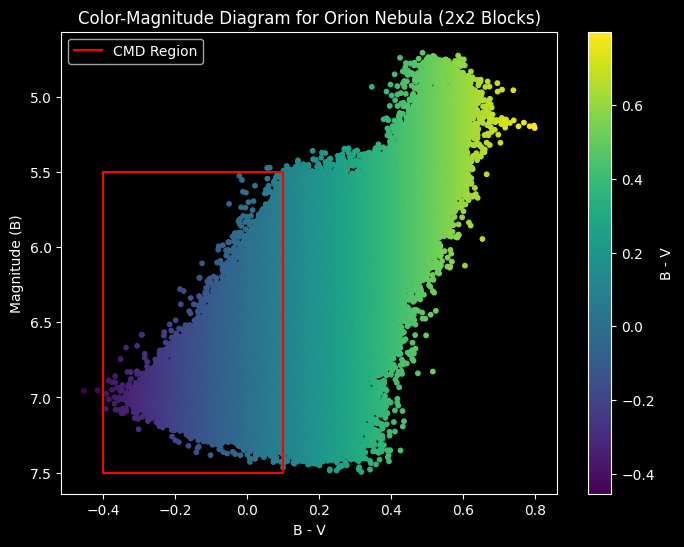

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
plt.style.use('dark_background')

orion_b_filename = '/content/drive/MyDrive/SeniorLab_OrionProject/starless_Target_Orion_Nebula_Keegan_Mihir_12352880_B_002.fit'
orion_v_filename = '/content/drive/MyDrive/SeniorLab_OrionProject/starless_Target_Orion_Nebula_Keegan_Mihir_12352880_V_001.fit'

hdu_orion_b = fits.open(orion_b_filename)
hdu_orion_v = fits.open(orion_v_filename)

orion_b = hdu_orion_b[0].data
orion_v = hdu_orion_v[0].data

def flux_to_magnitude(flux):
  if isinstance(flux, (int, float)):
    if flux <= 0:
      return np.nan
  else:
    if np.any(flux <= 0):
      return np.full(flux.shape, np.nan)
  return -2.5 * np.log10(flux)

# Prompt user for bin size
bin_size = int(input("Enter block size (e.g., 10): "))

height, width = orion_b.shape

# Calculate new dimensions
new_h = height // bin_size
new_w = width // bin_size

# Reshape and average over blocks
orion_b_binned = orion_b[:new_h * bin_size, :new_w * bin_size].reshape(new_h, bin_size, new_w, bin_size).mean(axis=(1, 3))
orion_v_binned = orion_v[:new_h * bin_size, :new_w * bin_size].reshape(new_h, bin_size, new_w, bin_size).mean(axis=(1, 3))

# Convert to magnitudes
b_mag = flux_to_magnitude(orion_b_binned)
v_mag = flux_to_magnitude(orion_v_binned)
b_v_color = b_mag - v_mag

# Create coordinate grid of block centers
y_indices, x_indices = np.indices(b_mag.shape)
x_coords = x_indices * bin_size + bin_size // 2
y_coords = y_indices * bin_size + bin_size // 2

# Flatten for plotting
b_mag_flat = b_mag.flatten()
b_v_flat = b_v_color.flatten()
x_flat = x_coords.flatten()
y_flat = y_coords.flatten()

# Create colormap
import matplotlib.cm as cm
norm = plt.Normalize(vmin=np.nanmin(b_v_flat), vmax=np.nanmax(b_v_flat))
colors = cm.viridis(norm(b_v_flat))

# Define region of interest in CMD space
bv_min, bv_max = -0.4, 0.1
bmag_min, bmag_max = 5.5, 7.5

# Plot CMD with region perimeter
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(b_v_flat, b_mag_flat, s=10, c=colors)

# Draw rectangle perimeter
rect_x = [bv_min, bv_max, bv_max, bv_min, bv_min]
rect_y = [bmag_min, bmag_min, bmag_max, bmag_max, bmag_min]
ax.plot(rect_x, rect_y, color='red', linewidth=1.5, label='CMD Region')

plt.xlabel("B - V")
plt.ylabel("Magnitude (B)")
plt.title(f"Color-Magnitude Diagram for Orion Nebula ({bin_size}x{bin_size} Blocks)")
plt.gca().invert_yaxis()
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="B - V", ax=ax)
plt.legend()
plt.show()

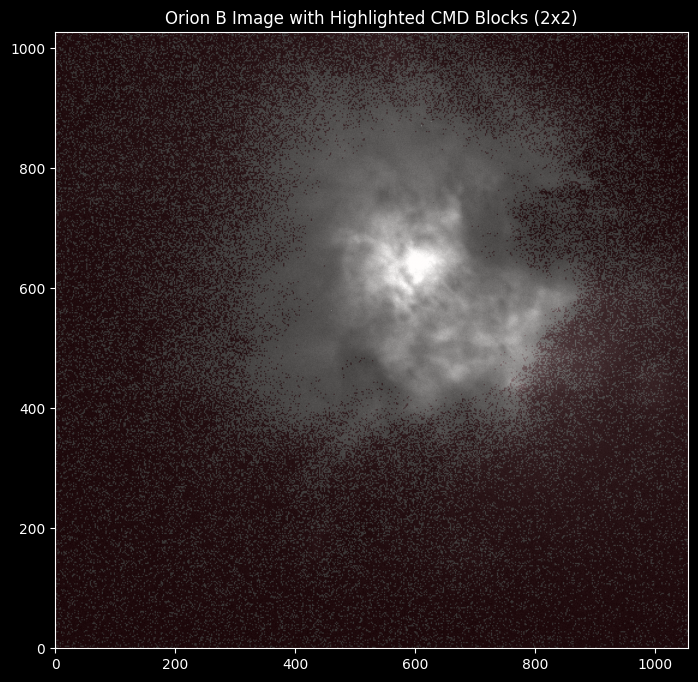

In [ ]:
# Find indices where CMD values fall in the region
roi_mask = (
    (b_v_flat >= bv_min) & (b_v_flat <= bv_max) &
    (b_mag_flat >= bmag_min) & (b_mag_flat <= bmag_max)
)

x_roi = x_flat[roi_mask]
y_roi = y_flat[roi_mask]

# Plot the B image with highlighted block heatmap
highlight_mask = np.zeros_like(orion_b, dtype=float)
for x, y in zip(x_roi, y_roi):
    x_start = max(0, x - bin_size // 2)
    x_end = min(width, x + bin_size // 2)
    y_start = max(0, y - bin_size // 2)
    y_end = min(height, y + bin_size // 2)
    highlight_mask[y_start:y_end, x_start:x_end] = 1.0

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(orion_b, cmap='gray', origin='upper', vmax=np.percentile(orion_b, 99.9), vmin=np.percentile(orion_b, 0.1))
ax.imshow(highlight_mask, cmap='Reds', alpha=0.2, origin='lower')
plt.title(f"Orion B Image with Highlighted CMD Blocks ({bin_size}x{bin_size})")
plt.show()

# With a slider

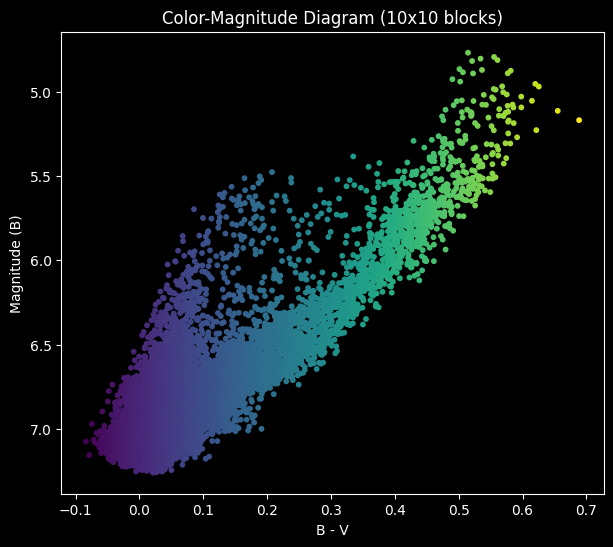

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.io.fits as fits
from ipywidgets import interact, IntSlider, FloatText, VBox, Button, HBox, Output
plt.style.use('dark_background')

# Load FITS data
orion_b_filename = '/content/drive/MyDrive/SeniorLab_OrionProject/starless_Target_Orion_Nebula_Keegan_Mihir_12352880_B_002.fit'
orion_v_filename = '/content/drive/MyDrive/SeniorLab_OrionProject/starless_Target_Orion_Nebula_Keegan_Mihir_12352880_V_001.fit'

hdu_orion_b = fits.open(orion_b_filename)
hdu_orion_v = fits.open(orion_v_filename)
orion_b = hdu_orion_b[0].data
orion_v = hdu_orion_v[0].data

def flux_to_magnitude(flux):
    if isinstance(flux, (int, float)):
        return np.nan if flux <= 0 else -2.5 * np.log10(flux)
    return np.where(flux <= 0, np.nan, -2.5 * np.log10(flux))

# Global variables to cache processed values
cached = {}

def generate_cmd(bin_size):
    height, width = orion_b.shape
    new_h, new_w = height // bin_size, width // bin_size

    b_binned = orion_b[:new_h*bin_size, :new_w*bin_size].reshape(new_h, bin_size, new_w, bin_size).mean(axis=(1, 3))
    v_binned = orion_v[:new_h*bin_size, :new_w*bin_size].reshape(new_h, bin_size, new_w, bin_size).mean(axis=(1, 3))

    b_mag = flux_to_magnitude(b_binned)
    v_mag = flux_to_magnitude(v_binned)
    b_v_color = b_mag - v_mag

    y_idx, x_idx = np.indices(b_mag.shape)
    x_coords = x_idx * bin_size + bin_size // 2
    y_coords = y_idx * bin_size + bin_size // 2

    b_mag_flat = b_mag.flatten()
    b_v_flat = b_v_color.flatten()
    x_flat = x_coords.flatten()
    y_flat = y_coords.flatten()

    norm = plt.Normalize(vmin=np.nanmin(b_v_flat), vmax=np.nanmax(b_v_flat))
    colors = cm.viridis(norm(b_v_flat))

    cached['b_v_flat'] = b_v_flat
    cached['b_mag_flat'] = b_mag_flat
    cached['x_flat'] = x_flat
    cached['y_flat'] = y_flat
    cached['bin_size'] = bin_size

    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(b_v_flat, b_mag_flat, s=10, c=colors)
    ax.set_xlabel("B - V")
    ax.set_ylabel("Magnitude (B)")
    ax.set_title(f"Color-Magnitude Diagram ({bin_size}x{bin_size} blocks)")
    ax.invert_yaxis()
    plt.show()

def highlight_image(bv_min, bv_max, bmag_min, bmag_max):
    b_v_flat = cached['b_v_flat']
    b_mag_flat = cached['b_mag_flat']
    x_flat = cached['x_flat']
    y_flat = cached['y_flat']
    bin_size = cached['bin_size']
    height, width = orion_b.shape

    roi_mask = (
        (b_v_flat >= bv_min) & (b_v_flat <= bv_max) &
        (b_mag_flat >= bmag_min) & (b_mag_flat <= bmag_max)
    )

    x_roi = x_flat[roi_mask]
    y_roi = y_flat[roi_mask]

    highlight_mask = np.zeros_like(orion_b, dtype=float)
    for x, y in zip(x_roi, y_roi):
        x_start = max(0, x - bin_size // 2)
        x_end = min(width, x + bin_size // 2)
        y_start = max(0, y - bin_size // 2)
        y_end = min(height, y + bin_size // 2)
        highlight_mask[y_start:y_end, x_start:x_end] = 1.0

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(orion_b, cmap='gray', origin='lower')
    ax.imshow(highlight_mask, cmap='Reds', alpha=0.5, origin='lower')
    ax.set_title(f"Orion B Image with Highlighted CMD Region")
    plt.show()

# UI components
bin_slider = IntSlider(min=2, max=50, step=2, value=10, description='Block Size')
bv_min_input = FloatText(value=1.0, description='B-V min')
bv_max_input = FloatText(value=1.5, description='B-V max')
bmag_min_input = FloatText(value=14.0, description='B mag min')
bmag_max_input = FloatText(value=16.0, description='B mag max')
show_button = Button(description='Show Highlighted Pixels')
output = Output()

@output.capture(clear_output=True)
def on_slider_change(change):
    generate_cmd(change['new'])

def on_button_click(b):
    highlight_image(bv_min_input.value, bv_max_input.value, bmag_min_input.value, bmag_max_input.value)

bin_slider.observe(on_slider_change, names='value')
show_button.on_click(on_button_click)

display(VBox([bin_slider, HBox([bv_min_input, bv_max_input, bmag_min_input, bmag_max_input, show_button]), output]))

# Initial display
generate_cmd(bin_slider.value)



# gif of going through blocks